# Census income prediction

## Introduzione

Il progetto mira a definire dei modelli di machine learning in grado di predire lo stato economico sociale sulla base di alcune caratteristiche, quali titolo di studio, età, paese di origine, ore lavorate alla settimana ecc. Il dataset (presente sia su Kaggle che su UCI) raccoglie dati inerenti a una porzione di cittadini statunitensi prelevati dal US Census Bureau per l'anno 1994 (in aggiornamento).

Il nostro dataset è etichettato con due valori: <=50k, >50k. Queste due etichette indicano il guadagno annuale in migliaia di dollari di un lavoratore statunitense.
Le feature del dataset sono:
 - age: età della persona
 - workclass: macro categoria di tipo di lavoratore (a livello burocratico)
 - fnlwgt: peso assegnato dal US Census Bureau che indica quanto una certa istanza rappresenta la popolazione
 - education: livello di istruzione
 - education-num: codifica numerica del livello di istruzione
 - marital-status: stato civile
 - occupation: macro categoria di lavoro (a livello di settore)
 - relationship: ruolo familiare
 - race: etnia di appartenenza
 - sex: genere registrato
 - capital-gain: entrate economiche al di fuori del lavoro (es: investimento)
 - capital-loss: perdite economiche al di fuori del lavoro
 - hours-per-week: numero di ore lavorate alla settimana
 - native-country: paese di origine 

Come possiamo notare il dataset piò essere ridondante

## Analisi esplorativa

Per iniziare esploriamo le librerie necessarie

In [432]:
import warnings
warnings.filterwarnings('ignore')

In [433]:
!pip3 install -U ucimlrepo 
!pip install imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter
from io import StringIO
from ucimlrepo import fetch_ucirepo 

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


Scarichiamo da UCI il dataset 'Census Income' e studiamone alcune proprietà: abbiamo diversi tipi di dati a alcuni valori mancanti

In [434]:
# scarichiamo il dataset
dataset = fetch_ucirepo(id=2) 
  
# suddivisone del dataset in features e target come dataframe
X = dataset.data.features 
y = dataset.data.targets 


print(dataset.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [435]:
# osserviamo alcune informazioni generiche sul dataset
print(dataset.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [436]:
# osserviamo il dataset
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [437]:
# osserviamo il target
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48837,<=50K.
48838,<=50K.
48839,<=50K.
48840,<=50K.


Uniamo i due dataframe per lavorarci in questa fase iniziale

In [438]:
df = pd.concat([X, y], axis=1)

# esportiamo il dataset in un file csv 
df.to_csv('dataset.csv')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Osserviamo la forma del dataset: il numero di feature è consistente

In [439]:
df.shape

(48842, 15)

Cerchiamo maggiori informazioni sul dataset, come il tipo delle feature

In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Osserviamo le statistiche dei tipi numerici

In [441]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Cerchiamo eventuali valori duplicati

In [442]:
df.duplicated().sum()

29

Cerchiamo eventuali valori nulli

In [443]:
df.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Cerchiamo eventuali valori nan

In [444]:
df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Alcuni valori mancanti sono indicanti sono indicati con '?', mentre alti con ',,' in ogni caso stanti ad indicare NaN. La differenza tra queste due notazioni verrà trattata più avanti.

Verifichiamo il bilanciamento del dataset

<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64


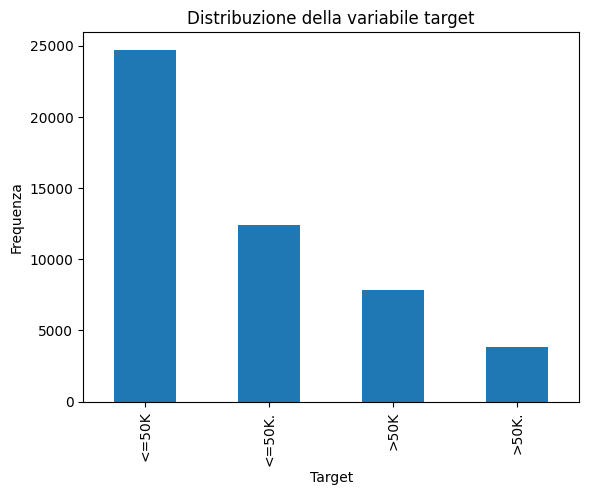

In [445]:
conteggio_valori = df['income'].value_counts()
print(conteggio_valori)

conteggio_valori.plot(kind='bar')
plt.title('Distribuzione della variabile target')
plt.xlabel('Target')
plt.ylabel('Frequenza')
plt.show()

Notiamo che la colonna income presenta più di due valori: accorperemo '<=50K' e '<=50K.' nello stesso valore. Lo stesso vale per '>50K' e '>50K.'
Il nostro problema è binario: definiamo true quando il guadagno è maggiore di 50k, false quando è minore o uguale. 

## Preprocessing

Il dataset presenta alcuni valori mancanti, duplicati e ridondanti. Inoltre è sbilanciato pertanto occorre adottare strategie di bilanciamento del target.
Possiamo eseguire alcune ottimizzazioni:
 - ottimizzazione e bilanciamento del target
 - gestione delle righe duplicate
 - gestione delle righe con valori null e nan
 - le colonne 'education' ed 'education num' potrebbero contenere le stesse informazioni
 - poichè i generi sono solo due (Male e Female) possiamo codificarli in 0 e 1.

Le colonne con valori mancanti sono: workclass, occupation e native-country. Tutte queste colonne sono di tipo Categorico.

### Gestione dei valori duplicati

In [446]:
# visualizziamo le righe con valori duplicati

df[df.duplicated()].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K


Le righe sono duplicate e non abbiamo chiavi primarie o criteri univoci per distringuerle, quindi potrebbe trattarsi di valori effettivamente doppi. Tuttavia non è da escludersi che per caso due persone abbiano le stesse features, per quanto raro. Di conseguenza le righe duplicate non verranno rimosse. (to finish)

### Gestione delle righe con valori null e Nan

Per prima cosa  modifichiamo la notazione del dataset

In [447]:
# traformiamo il dataframe in una stringa
df_string = df.to_csv(index=False)

# iteriamo sulla stringa e sostitutiamo tutte le occorrenze di '?' con ''
df_string = df_string.replace(',?,', ',,')

# trasformiamo la stringa in un dataframe
df = pd.read_csv(StringIO(df_string))

In [448]:
# esportiamo il dataset

df.to_csv('dataset_no_nan.csv', index=False)

Verifichiamo com'è cambiata la conta dei nan

In [449]:
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

Verifichiamo che le righe null e Nan siano le stesse

In [450]:
# estraimo le righe con valori null

null_values=df[df.isnull().any(axis=1)].head()

null_values

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K


In [451]:
# estraimo le righe con valori nan

nan_values=df[df.isna().any(axis=1)].head()

nan_values

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K


In [452]:
# controlliamo se sono uguali

null_values.equals(nan_values)

True

Ora che possiamo constatare che le righe con valori null e nan sono le stesse procediamo a gestirle. 
Useremo approci diversi

- Ragioniamo sulla colonna 'native country'.
  Come possiamo osservare il valore più frequente è 'Stati Uniti'. Il dataset raccoglie informazioni in merito a cittadini che lavorano negli Stati Uniti di origine statunitense e di altre origini dal US Census Bureau. 

  Essendo presenti nel dataset paesi di origine meno sviluppati degli Stati Uniti, ha senso assumere che tutti i cittadini il cui paese di origine non è noto non siano di origine statunitense. 

  Scrivere 'Stati Uniti' come 'native country' per imputare i dati mancanti potrebbere aggiungere bias. 

- Per quanto riguarda invece le colonne 'workclass' e 'occupation' è osservabile che (eccetto in rari casi) i valori null sono presenti sulle stesse righe. Questo potrebbe suggerire che una persona è attualmente senza lavoro, quindi conserveremo questa informazione.

#### Rimozione di valori nulli da 'native country'

Procediamo a gestire le righe con valori mancanti rimuovendole.

In [453]:
print ('Dimensione del dataset prima: ', df.shape)
numero_righe_prima = df.shape[0]

# eliminiamo le righe della colonna 'native-country' che contengono valori nulli
df = df.dropna(subset=['native-country'])

print ('Dimensione del dataset dopo: ', df.shape)
numero_righe_dopo = df.shape[0]
print ('Numero di righe eliminate: ', numero_righe_prima - numero_righe_dopo)

Dimensione del dataset prima:  (48842, 15)
Dimensione del dataset dopo:  (47985, 15)
Numero di righe eliminate:  857


Verifichiamo che le righe siano state eliminate

In [454]:
df.isna().sum()

age                  0
workclass         2753
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2763
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

#### Gestione dei valori nulli per 'workclass' e 'occupation'

Per quanto riguarda 'workclass' e 'occupation' la questione è diversa. Infatti è più logico pensare che i valori mancanti si riferiscano a una persona inoccupata, piuttosta che alla vera e propria incertezza del dato (ricordiamo che la fonte è il US Census Bureau).

Per eiliminare valori Nan sostituiremo i valori assenti con la stringa 'unoccupied'. Però c'è un problema, infatti i valori Nan nella colonna 'workclass' e nella colonna 'occupied' differiscono di 10. Studiamo queste 10 righe separatamente.

In [455]:
df[(df['workclass'].isnull()) ^ (df['occupation'].isnull())]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5361,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,157131,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,153663,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,<=50K
41346,17,Never-worked,131593,11th,7,Never-married,NaN,Own-child,Black,Female,0,0,20,United-States,<=50K.
44168,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,NaN,Other-relative,White,Male,0,0,35,United-States,<=50K.
46459,18,Never-worked,162908,11th,7,Never-married,NaN,Own-child,White,Male,0,0,35,United-States,<=50K.


Abbiamo scoperto che la differenza numerica è spiegata dal fatto che esistono persone nel dataset che non hanno mai lavorato.
Per queste istanze sostituiremo 'Never-worked' nella colonna 'occupation'

In [456]:
# scriviamo nel dataset temp_df 'Never-worked' nella colonna occupation per ogni riga

df.loc[(df['workclass'].isnull()) ^ (df['occupation'].isnull()), 'occupation'] = 'Never-worked'

df[(df['workclass'].isnull()) ^ (df['occupation'].isnull())]

In [457]:
df.isna().sum()

age                  0
workclass         2753
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2753
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

Infine sostituiamo i valori mancanti con la string 'unoccupied' nelle celle delle colonne 'workclass' e 'occupation' 

In [458]:
df['workclass'] = df['workclass'].fillna('unoccupied')
df['occupation'] = df['occupation'].fillna('unoccupied')

# esportiamo il dataset
df.to_csv('dataset_def.csv')

df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [467]:
# stampiamp alcune righe a caso del dataset

df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
48567,76,unoccupied,239900,HS-grad,9,Divorced,unoccupied,Not-in-family,White,Female,0,0,3,United-States,0
2172,41,Private,222142,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
16923,41,Private,143003,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,7298,0,60,India,1
28119,31,Private,221167,Prof-school,15,Divorced,Tech-support,Not-in-family,White,Female,0,0,35,United-States,0
27182,58,Federal-gov,139290,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,1
33485,29,Private,189565,HS-grad,9,Divorced,Protective-serv,Own-child,White,Male,0,0,40,United-States,0
17671,43,Local-gov,265698,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,45,United-States,1
32280,49,Private,255466,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,60,United-States,0
23605,20,Private,127185,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,15,United-States,0
23601,47,Local-gov,219632,Assoc-acdm,12,Separated,Exec-managerial,Not-in-family,White,Male,0,1408,40,United-States,0


### Pulizia della colonna 'target'

Rinominiamo la colonna 'income' con 'target' che è più convenzionale

In [459]:
df.rename(columns={'income':'target'}, inplace=True)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,unoccupied,321403,HS-grad,9,Widowed,unoccupied,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


Siccome nella colonna target i valori sono '>50K.', '>50K', '<=50K.' e '<=50K', accorpiamo i quattro valori in due rinominado '>50K.' in '>50K' e '<=50K.' in '<=50K'

In [460]:
df['target'] = df['target'].str.replace('.','')

conteggio_valori = df['target'].value_counts()
print(conteggio_valori)

<=50K    36518
>50K     11467
Name: target, dtype: int64


Convertiamo i tipi della colonna target da stringa a booleana secondo il criterio deciso in precedenza

In [461]:
df['target'] = df['target'].apply(lambda x: 1 if x == '>50K' else 0)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
48838,64,unoccupied,321403,HS-grad,9,Widowed,unoccupied,Other-relative,Black,Male,0,0,40,United-States,0
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


Osserviamo i valori della colonna target dopo aver eseguito questa piccola operazione di miglioramento

0    36518
1    11467
Name: target, dtype: int64


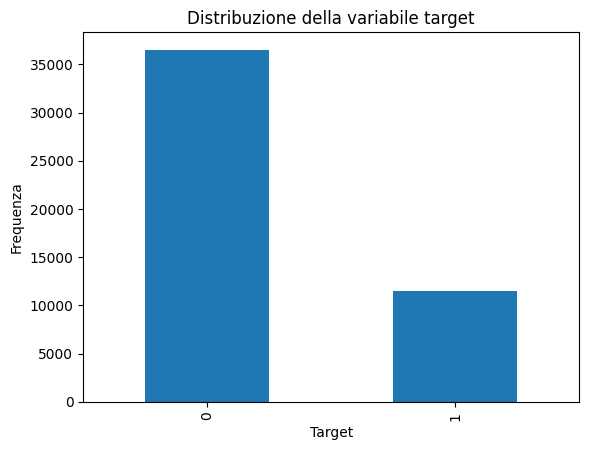

In [462]:
conteggio_valori = df['target'].value_counts()
print(conteggio_valori)

conteggio_valori.plot(kind='bar')
plt.title('Distribuzione della variabile target')
plt.xlabel('Target')
plt.ylabel('Frequenza')
plt.show()

### Bilanciamento della colonna 'target'

Siccome il nostro dataset è abbastanza popolato procederemo con la tecnica di oversampling 'Smote'

In [463]:
'''
smote = SMOTE(sampling_strategy='minority')

X_resampled, y_resampled = smote.fit_resample(X, y)

print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_resampled))
'''

"\nsmote = SMOTE(sampling_strategy='minority')\n\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\nprint('Original dataset shape %s' % Counter(y))\nprint('Resampled dataset shape %s' % Counter(y_resampled))\n"

Procediamo con la tecnica di undersampling 'Tomek links'

In [464]:

'''
# Stampiamo la distribuzione delle classi prima dell'undersampling
print("Distribuzione delle classi prima dell'undersampling:", Counter(y))

# Creiamo un oggetto TomekLinks
tomek_links = TomekLinks()

# Applichiamo l'undersampling ai nostri dati
X_resampled, y_resampled = tomek_links.fit_resample(X, y)

# Stampiamo la distribuzione delle classi dopo l'undersampling
print("Distribuzione delle classi dopo l'undersampling:", Counter(y_resampled))

'''

'\n# Stampiamo la distribuzione delle classi prima dell\'undersampling\nprint("Distribuzione delle classi prima dell\'undersampling:", Counter(y))\n\n# Creiamo un oggetto TomekLinks\ntomek_links = TomekLinks()\n\n# Applichiamo l\'undersampling ai nostri dati\nX_resampled, y_resampled = tomek_links.fit_resample(X, y)\n\n# Stampiamo la distribuzione delle classi dopo l\'undersampling\nprint("Distribuzione delle classi dopo l\'undersampling:", Counter(y_resampled))\n\n'